In [2]:
import IPython
from scipy.io import wavfile
import matplotlib.pyplot as plt
import numpy as np
import librosa as lib
from librosa import display
import seaborn as sns
from scipy.signal import hilbert, chirp
from scipy.fftpack import fft, dct, idct
from scipy.fft import fftfreq
sns.set_theme(style="whitegrid")

#Funciones
def media_movil(t,y,HW):
    import numpy as np
    """
    Calculo de la media movil
    """
    N = np.size(y)
    W = np.round(2*HW).astype(int)
   
    ymm = np.zeros(N-2*HW)
    tmm = np.zeros(N-2*HW)
   
    for i in np.arange(HW,N-HW):
        ymm[i-HW] = np.mean( y[i-HW:i+HW] )
        tmm[i-HW] = t[i]
       
    return tmm, ymm

def hallar_picos(to,yo,HW,Npasadas=1):
    import numpy as np
   
    tS = to
    yS = yo
   
    for i in range(Npasadas):
        tS, yS = media_movil(tS,yS,HW)
   
    tp = np.empty((0, 1))
    yp = np.empty((0, 1))
   
    for i in range(1,len(yS)-1):
        if (yS[i-1] < yS[i] ) & (yS[i] > yS[i+1]):
            idx = np.where(to==tS[i])
            tp = np.append(tp, [to[idx]])
            yp = np.append(yp, [yo[idx]])
   
    return tp, yp

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

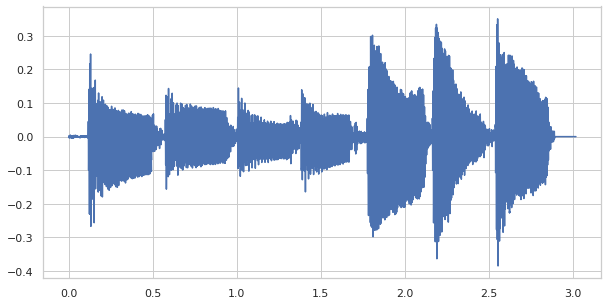

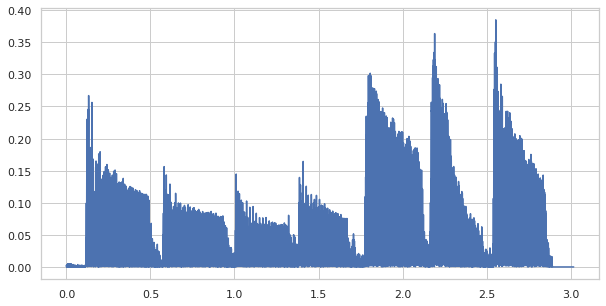

In [3]:
#Carga de datos
nombre = '/home/felipe/Documentos/tesis/datos_entrenamiento/si_bemol_mayor_guitarra'
sufijo = '.wav'
file_path = nombre + sufijo         
samples, sampling_rate = lib.load(file_path)    
duration_of_sound = len(samples)/sampling_rate
sr=sampling_rate
time= np.linspace(0,duration_of_sound,len(samples))
plt.figure(figsize=(10,5))
plt.plot(time,samples)

plt.figure(figsize=(10,5))
plt.plot(time,np.abs(samples))

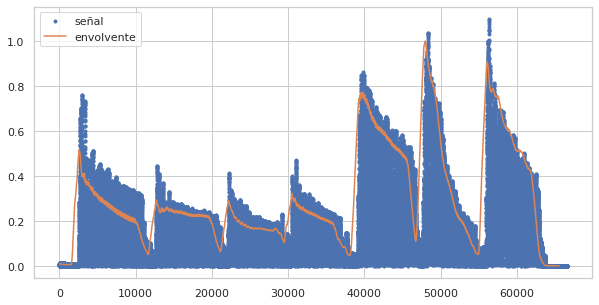

In [4]:
#Envolvente y suavidad
signal = samples
analytic_signal= hilbert(signal) #envolvente entera
#signal *= (1.0 + 0.5='rt(signal,N=None))
amplitude_envelope = np.abs(analytic_signal) #en modulo


amplitude_envelope=moving_average(amplitude_envelope,1000) #suavizo
time_envelope= np.linspace(0,duration_of_sound,len(amplitude_envelope))
    #graficos
plt.figure(figsize=(10,5))
plt.plot(np.abs(samples)/np.max(samples),'.', label='señal')
plt.plot(amplitude_envelope/np.max(amplitude_envelope),'-', label='envolvente')

plt.legend()
plt.show()


oenv = lib.onset.onset_strength(y=amplitude_envelope, sr=sampling_rate)
times = lib.times_like(oenv)
# Detect events without backtracking
onset_raw = lib.onset.onset_detect(onset_envelope=oenv,
                                       backtrack=False)
onset_bt = lib.onset.onset_backtrack(onset_raw, oenv)

#plt.figure(figsize=(10,5))
#plt.vlines(onset_bt,ymin=0, ymax=max_env)
#plt.legend()
#plt.show()

#plt.figure(figsize=(10,5))
#plt.plot(times, oenv, label='Onset strength')
#plt.vlines(lib.frames_to_time(onset_raw), 0, oenv.max(), label='Raw onsets', color='k')
#plt.vlines(lib.frames_to_time(onset_bt), 0, oenv.max(), label='Backtracked', color='r')
#plt.legend()
#plt.label_outer()

#plt.figure(figsize=(10,5))
#plt.plot(time_envelope,amplitude_envelope,'-', label='envolvente')
#plt.legend()
#plt.show()

#plt.figure(figsize=(10,5))
#plt.plot(np.abs(samples),'.', label='señal')
#plt.legend()
#plt.show()


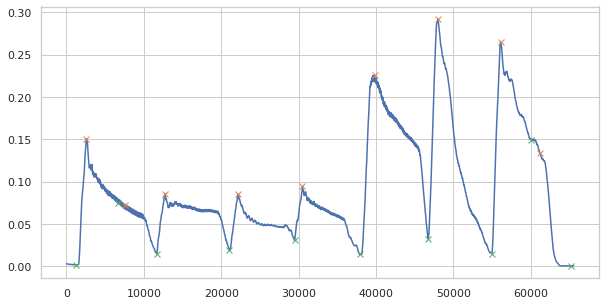

In [8]:
#maximos
from scipy.signal import find_peaks
peaks, _ = find_peaks(amplitude_envelope, height=0.01, distance=5000)
mins,_=find_peaks(-amplitude_envelope, distance=5000)
plt.figure(figsize=(10,5))
plt.plot(amplitude_envelope)
plt.plot(peaks, amplitude_envelope[peaks], "x")
plt.plot(mins, amplitude_envelope[mins], "x")
plt.show()


#plt.figure(figsize=(10,5))
#plt.plot(np.abs(samples)/np.max(samples),'.', label='señal')
#plt.plot(amplitude_envelope/np.max(amplitude_envelope),'-', label='envolvente')
#plt.plot(peaks,amplitude_envelope[peaks]/np.max(amplitude_envelope[peaks]), "x")
#plt.plot(mins, amplitude_envelope[mins]/np.max(amplitude_envelope[mins]), "x")

#plt.legend()
#plt.show()

#saco el primer y ultimo minimo que veo que sobran

In [10]:
#saco los que estan mal


mins_aux=np.delete(mins,1)
mins_arreglados=mins_aux[0:-2]
peaks_arreglados=np.delete(peaks,1)
peaks_arreglados=peaks_arreglados[0:-1]

print(mins_arreglados)
print(peaks_arreglados)

[ 1249 11662 21073 29475 37957 46746 54960]
[ 2574 12742 22169 30508 39814 48007 56132]


In [11]:
#tiempos retiramo puntos raros
#mins_arreglados_aux=mins[1:]
#mins_arreglados=mins_arreglados_aux[0:-1]
#peaks_arreglados=peaks[1:]
tiempo_minimos=time_envelope[mins_arreglados]
tiempo_maximos=time_envelope[peaks_arreglados]

tiempo_ataque=tiempo_maximos-tiempo_minimos

log_tiempos_ataque=np.log10(tiempo_ataque)
print(log_tiempos_ataque)
print(np.median(log_tiempos_ataque))
print(np.mean(log_tiempos_ataque))
print(np.std(log_tiempos_ataque))

[-1.21461835 -1.30341047 -1.29702367 -1.3227339  -1.06802232 -1.23611914
 -1.26790661]
-1.2679066137375778
-1.2442620666449822
0.08018257689958995


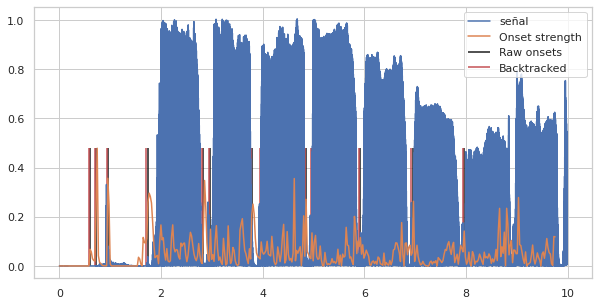

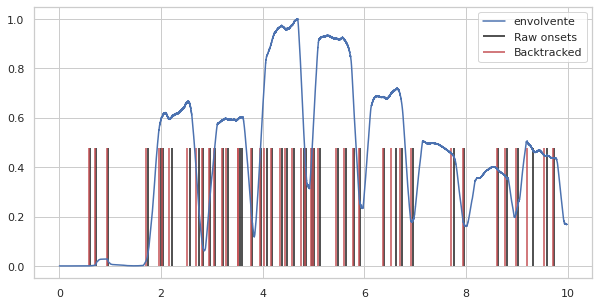

In [29]:
#Figuritas

plt.figure(figsize=(10,5))
plt.plot(time,np.abs(samples)/np.max(samples), label='señal')
plt.plot(times, oenv, label='Onset strength')
#plt.plot(time,samples, label='señal')
plt.vlines(lib.frames_to_time(onset_raw), 0, oenv.max(), label='Raw onsets', color='k')
plt.vlines(lib.frames_to_time(onset_bt), 0, oenv.max(), label='Backtracked', color='r')
plt.legend()
#plt.label_outer()
#plt.xlim(0.6,1)
plt.show()


plt.figure(figsize=(10,5))
plt.plot(time_envelope,amplitude_envelope/np.max(amplitude_envelope),'-', label='envolvente')
#plt.plot(times, oenv, label='Onset strength')
#plt.plot(time,samples, label='señal')
plt.vlines(lib.frames_to_time(onset_raw), 0, oenv.max(), label='Raw onsets', color='k')
plt.vlines(lib.frames_to_time(onset_bt), 0, oenv.max(), label='Backtracked', color='r')
plt.legend()
#plt.label_outer()
#plt.xlim(2.6,3)
plt.show()

In [52]:
tiempo_ataque= onset_raw-onset_bt
log_tiempos_ataque=np.log10(tiempo_ataque)
print(log_tiempos_ataque)
print(np.median(log_tiempos_ataque))

[0.47712125 0.60205999 0.69897    0.30103    0.47712125 0.60205999
 0.30103    0.        ]
0.47712125471966244


### 